# 利用pytorch的nn工具箱实现LeNet网络

## 定义网络

In [3]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # nn.Module 子类的函数必须在构造函数中执行父类的构造函数
        
        #卷积层
        self.conv1 = nn.Conv2d(1,6,5) # '1'表示输入图片为单通道，‘6’表示输出通道数，‘5’表示卷积核为 5*5
        self.conv2 = nn.Conv2d(6,16,5)
        
        #全连接层 y = wx + b
        self.fc1 = nn.Linear(16 * 5 * 5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        #卷积 -> 激活 -> 池化
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        
        #reshape
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

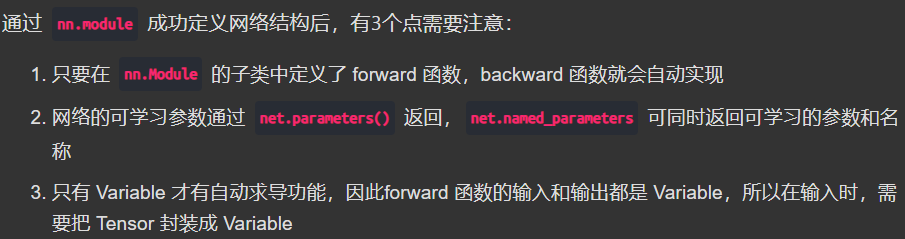

In [4]:
params = list(net.parameters())
print(len(params))
for name, parameters in net.named_parameters():
    print(f'{name}: {parameters.size()}')

10
conv1.weight: torch.Size([6, 1, 5, 5])
conv1.bias: torch.Size([6])
conv2.weight: torch.Size([16, 6, 5, 5])
conv2.bias: torch.Size([16])
fc1.weight: torch.Size([120, 400])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([84, 120])
fc2.bias: torch.Size([84])
fc3.weight: torch.Size([10, 84])
fc3.bias: torch.Size([10])


In [6]:
input = V(t.randn(1, 1, 32, 32))  # 定义输入
out = net(input)
out.size()  # 输出的形状
net.zero_grad()  # 所有参数的梯度清零
out.backward(V(t.ones(1, 10)))  # 反向传播

## 损失函数
nn 实现了神经网络中大多数的损失函数，例如**nn.MSELoss**计算均方误差，**nn.CrossEntropyLoss**计算交叉熵损失。

In [9]:
output = net(input)
target = V(t.arange(0,10)).view(1,10).float()
criterion = nn.MSELoss()
loss = criterion(output,target)
loss

tensor(28.7312, grad_fn=<MseLossBackward>)

In [10]:
# 运行.backward，观察调用之前和调用之后的 grad
net.zero_grad()  # 把 net 中所有可学习参数的梯度清零
print(f'反向传播之前conv1.bias 的梯度：{net.conv1.bias.grad}')
loss.backward()
print(f'反向传播之后conv1.bias 的梯度：{net.conv1.bias.grad}')

反向传播之前conv1.bias 的梯度：tensor([0., 0., 0., 0., 0., 0.])
反向传播之后conv1.bias 的梯度：tensor([-0.0120,  0.0170, -0.0271,  0.0434, -0.0142,  0.0245])


## 优化器
在反向传播完成所有参数的梯度计算后，还需要使用优化方法更新网络的权重和参数。

In [11]:
import torch.optim as optim

#新建一个优化器 指定要调整的参数和学习率
optimizer = optim.SGD(net.parameters(),lr=0.01)

#在训练过程中先将梯度清零
optimizer.zero_grad()

#计算损失
output = net(input)
loss = criterion(output,target)

#反向传播
loss.backward()

#更新参数
optimizer.step()

## 数据加载和预处理

# nn.Module
torch.nn 的核心数据结构就是 Module，它可以看做是某一层，也可以看做是整个神经网络。**最常见的做法就是直接继承 nn.module，然后构建自己的网络模型结构。**

## 构建一层网络——全连接层
 + 在构造函数中必须自己定义可学习的参数，并且要封装为 Parameter，下面代码则是把 w 和 b 封装成 Parameter，并且可以发现 Parameter 这种数据结构默认 requires_grad=True

In [33]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

class Linear(nn.Module):
    def __init__(self,in_features,out_feartures):
        super(Linear,self).__init__() # nn.Module 子类的函数必须在构造函数中执行父类的构造函数
        self.w = nn.Parameter(t.randn(in_features,out_feartures))
        self.b = nn.Parameter(t.randn(out_feartures))
        
    def forward(self,x):
        x = x.mm(self.w)
        return x + self.b.expand_as(x)
    
layer = Linear(4,3)
input = V(t.randn(2,4))
output = layer(input)
output

tensor([[-1.1642, -0.2752, -2.5553],
        [-3.0523,  0.8015, -0.5746]], grad_fn=<AddBackward0>)

In [34]:
for name, parameter in layer.named_parameters():
    print(name, parameter)

w Parameter containing:
tensor([[ 1.0992, -1.0917, -0.2725],
        [ 0.3973,  0.8010, -1.6401],
        [-1.0968, -0.7043,  0.1773],
        [ 1.0017,  1.2407, -0.1232]], requires_grad=True)
b Parameter containing:
tensor([-0.5293, -0.1648, -1.2041], requires_grad=True)


## 构建多层网络——多层感知机

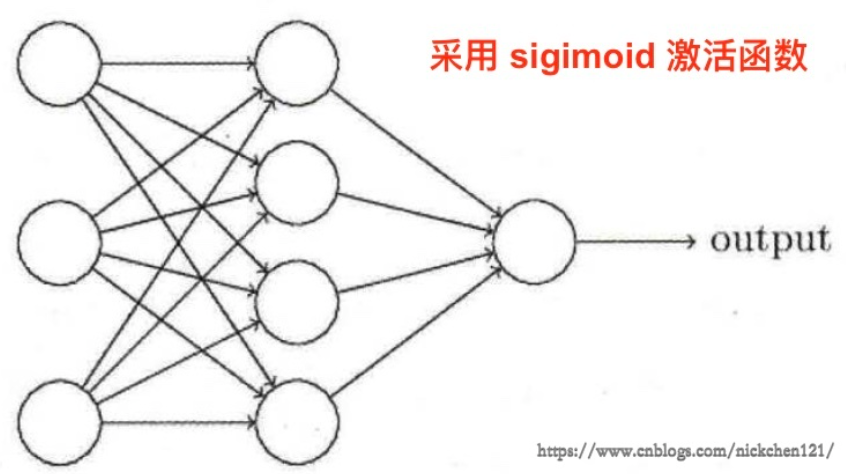

In [38]:
class Perception(nn.Module):
    def __init__(self,in_feartures,hidden_feartures,out_feartures):
        super(Perception,self).__init__()
        self.layer1 = Linear(in_feartures,hidden_feartures)
        self.layer2 = Linear(hidden_feartures,out_feartures)
        
    def forward(self,w):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)
    
perceptron = Perception(3,4,1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])
